In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-csv/train.csv
/kaggle/input/train2-csv/Sampled_30__Dataset.csv


In [2]:
# Install necessary libraries
!pip install transformers torch pandas scikit-learn matplotlib nltk seaborn imbalanced-learn 


In [3]:
!pip install nltk pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 49.0 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Class distribution:
 label
7     17230
9      3642
0      3263
3      1082
11      847
13      551
5       513
12      466
2       144
8       133
1       114
6        55
4        48
10       17
Name: count, dtype: int64
Class distribution after SMOTE balancing:
7     13788
5     13788
0     13788
9     13788
3     13788
13    13788
8     13788
11    13788
12    13788
2     13788
6     13788
1     13788
10    13788
4     13788
Name: count, dtype: int64


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.157100,1.862025,0.563601,0.602707
2,0.107200,1.966188,0.626935,0.655268
3,0.076400,3.085794,0.557374,0.595135
4,0.046800,3.233964,0.587974,0.623460
5,0.027000,3.466121,0.594378,0.626192


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

Ensemble Model Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.19      0.25       642
           1       0.10      0.14      0.12        21
           2       0.09      0.23      0.13        35
           3       0.97      1.00      0.98       217
           4       0.00      0.33      0.00         6
           5       0.28      0.16      0.20       102
           6       0.01      0.07      0.01        14
           7       0.92      0.54      0.68      3442
           8       0.01      0.21      0.02        34
           9       0.56      0.41      0.47       749
          10       0.00      0.00      0.00         4
          11       0.63      0.91      0.75       163
          12       0.09      0.02      0.04        85
          13       0.33      0.01      0.02       107

    accuracy                           0.48      5621
   macro avg       0.31      0.30      0.26      5621
weighted avg       0.75      0.48      0.

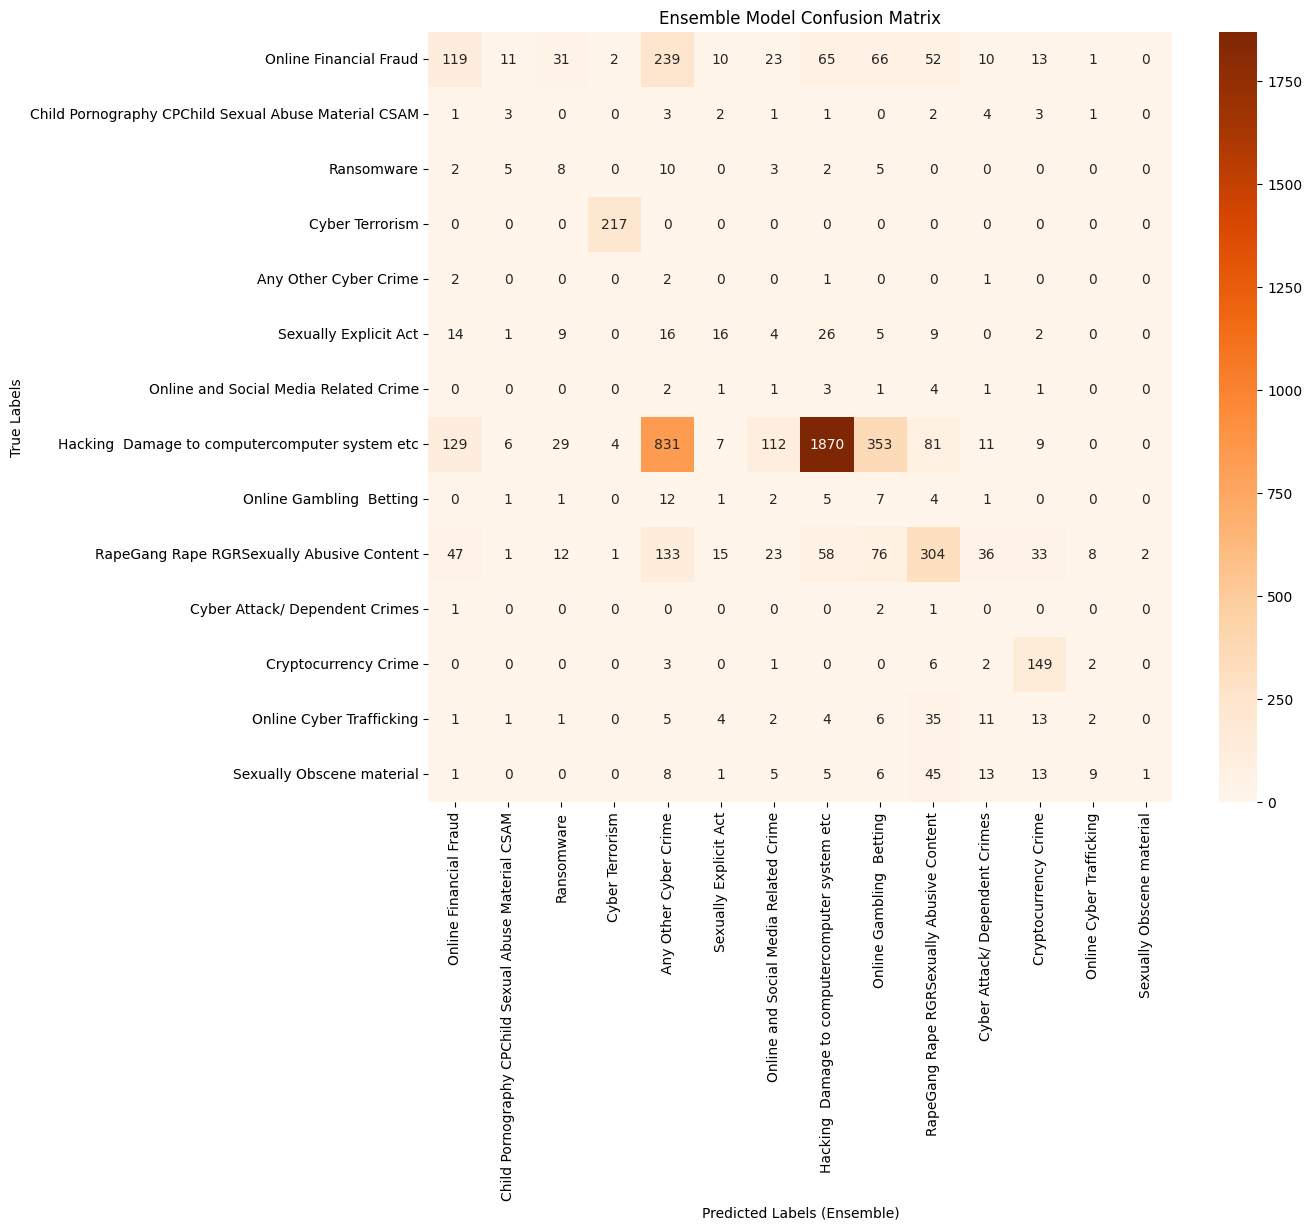

In [4]:
import pandas as pd
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from nltk.corpus import stopwords
import nltk
import os
from imblearn.over_sampling import SMOTE
import numpy as np

# Disable Weights and Biases
os.environ["WANDB_DISABLED"] = "true"

# Download necessary NLTK data
nltk.download('stopwords')

# Define stop words
nltk_stop_words = set(stopwords.words('english'))
generic_stop_words = [
    "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are",
    "aren't", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both",
    "but", "by", "could", "couldn't", "did", "didn't", "do", "does", "doesn't", "doing", "don't",
    "down", "during", "each", "few", "for", "from", "further", "had", "hadn't", "has", "hasn't",
    "have", "haven't", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers",
    "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if",
    "in", "into", "is", "isn't", "it", "it's", "its", "itself", "let's", "me", "more", "most",
    "mustn't", "my", "myself", "no", "nor", "not", "of", "off", "on", "once", "only", "or", "other",
    "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "shan't", "she", "she'd",
    "she'll", "she's", "should", "shouldn't", "so", "some", "such", "than", "that", "that's", "the",
    "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd",
    "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
    "very", "was", "wasn't", "we", "we'd", "we'll", "we're", "we've", "were", "weren't", "what",
    "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom",
    "why", "why's", "with", "won't", "would", "wouldn't", "you", "you'd", "you'll", "you're",
    "you've", "your", "yours", "yourself", "yourselves"
]
project_specific_stop_words = [
    "complaint", "victim", "fraud", "type", "based", "model", "data", "preprocessing",
    "categorizes", "classification", "used", "develop", "development", "parameters",
    "accuracy", "precision", "recall", "f1", "score", "evaluate", "evaluation", "prepare", "final",
    "text", "tokenization", "cleaning", "stemming", "removal", "output", "outputs"
]

# Combine stop words
stop_words = nltk_stop_words.union(generic_stop_words, project_specific_stop_words)

# Preprocess function for text data without lemmatization and spell checking
def preprocess_text(text):
    if not isinstance(text, str):
        text = ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetical characters
    tokens = text.split()
    tokens = [word for word in tokens if word and word not in stop_words]
    return ' '.join(tokens)

# Load dataset
data = pd.read_csv('/kaggle/input/train2-csv/Sampled_30__Dataset.csv')  # Adjust path if using Google Drive

# Preprocess text column
data['processed_text'] = data['crimeaditionalinfo'].fillna('').astype(str).apply(preprocess_text)  # Adjust column name if needed
data['label'] = data['category'].factorize()[0]  # Convert target labels to numerical values

# Check for class imbalance
class_counts = data['label'].value_counts()
print("Class distribution:\n", class_counts)

# Split the data before oversampling
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['processed_text'], data['label'], test_size=0.2, random_state=42
)

# Convert train_texts to TF-IDF features for SMOTE
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5)
X_train_tfidf = tfidf.fit_transform(train_texts)
y_train = np.array(train_labels)

# Apply SMOTE to balance classes in training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

print("Class distribution after SMOTE balancing:")
print(pd.Series(y_train_balanced).value_counts())

# Update train_texts and train_labels after SMOTE
train_texts = tfidf.inverse_transform(X_train_balanced)
train_labels = y_train_balanced

# Flatten the list of lists obtained from inverse_transform
train_texts = [' '.join(text) for text in train_texts]

### DistilBERT Model Training and Evaluation ###
# Define tokenizer and tokenize data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=128, return_tensors='pt')
val_encodings = tokenizer(val_texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')

# Create Dataset Class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels.tolist())

# Load DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=len(set(data['label']))
)

# Define Training Arguments with more epochs and evaluation metrics
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    per_device_train_batch_size=8,  # Smaller batch size for better generalization
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # Increased number of epochs for better learning
    weight_decay=0.1,
    learning_rate=2e-5,  # Lower learning rate for more stable training
    load_best_model_at_end=True,
    save_total_limit=2,
    lr_scheduler_type="linear",
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        'f1_weighted': f1_score(p.label_ids, np.argmax(p.predictions, axis=1), average='weighted')
    }
)

# Train the model
trainer.train()

# Evaluate the DistilBERT model
predictions = trainer.predict(val_dataset)
distilbert_preds = np.argmax(predictions.predictions, axis=1)

# XGBoost model training and evaluation
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(set(data['label'])), eval_metric='mlogloss')
xgb_model.fit(X_train_balanced, y_train_balanced)

# Predict on test set using XGBoost
xgb_preds = xgb_model.predict(tfidf.transform(val_texts))

# Ensemble using VotingClassifier
voting_model = VotingClassifier(estimators=[
    ('distilbert', xgb_model),
    ('xgb', xgb_model)
], voting='soft')

# Train VotingClassifier with predictions of trained models
combined_preds = [distilbert_preds, xgb_preds]
ensemble_preds = np.round(np.mean(combined_preds, axis=0)).astype(int)

# Print Classification Report, F1 Score, and Accuracy for the Ensemble Model
print("Ensemble Model Classification Report:\n", classification_report(val_labels, ensemble_preds))
print("Ensemble Model F1 Score:", f1_score(val_labels, ensemble_preds, average='weighted'))
print("Ensemble Model Accuracy Score:", accuracy_score(val_labels, ensemble_preds))

# Confusion Matrix for Ensemble Model
ensemble_conf_matrix = confusion_matrix(val_labels, ensemble_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(ensemble_conf_matrix, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=set(data['category']), yticklabels=set(data['category']))
plt.xlabel('Predicted Labels (Ensemble)')
plt.ylabel('True Labels')
plt.title('Ensemble Model Confusion Matrix')
plt.show()
